<a href="https://colab.research.google.com/github/nyp-sit/sdaai-iti103/blob/master/session-4/classification_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

We have worked with regression type of problem in the previous exercise. Let us now take a closer look at classification type of problem.  

We will work with both binary classification and multi-class classification problems, and learn to compute different metrics to evaluate a classification model. 

## Binary Classification

### Dataset

We will be using an SMS spam/ham dataset and build a binary classification model to help us predict if a text message is a spam or not. 

Let's go head and load the data into a panda dataframe and look at the first few samples.

In [1]:
import pandas as pd

data_url = "https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/smsspamcollection.tsv"
df = pd.read_csv(data_url, sep="\t")
df.head()

  label  ... punct
0   ham  ...     9
1   ham  ...     6
2  spam  ...     6
3   ham  ...     6
4   ham  ...     2

[5 rows x 4 columns]

### Data Preparation

Let's see what are the different labels we have. 

In [2]:
df["label"].unique()

array(['ham', 'spam'], dtype=object)

You will notice that we have two different labels: 'ham' and 'spam', both a text string (dtype=object)

As most of the evaluation metrics in scikit-learn assume (by default) positive label as 1 and negative label as 0, for convenience, we will first convert the label to 1 and 0. As our task is to detect spam, the positive label (label 1) in our case will be for spam.  

Let's create a mapping to map the string label to its corresponding numeric label and use the pandas [map()](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)  function to change the label to numeric label. 

In [ ]:
labelmap = {"ham": 0, "spam": 1}

df["label"] = df["label"].map(labelmap)

In [3]:
df.head()

   label  ... punct
0      0  ...     9
1      0  ...     6
2      1  ...     6
3      0  ...     6
4      0  ...     2

[5 rows x 4 columns]

Always a good practice to check if there is any missing values, using ``isnull()`` method of dataframe.

In [4]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

Let's get a sense of the distribution of positive and negative cases to see if we are dealing with imbalanced dataset.

In [5]:
df["label"].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

You will see that we have a lot more 'ham' messages than 'spam' messages: 4825 out of 5572 messages, or 86.6%, are ham. This means that any text classification model we create has to perform **better than 86.6%** to beat random chance. 

### Split data into train and test set

We will have to first decide what we want to use as features. For this lab, let us just start simply, only use the text message and ignore others like punctuation and message length. 

We then split the data randomly into 80-20 split of train and test set.

In [ ]:
from scipy.sparse import random
from sklearn.model_selection import train_test_split

X = df["message"]  # this time we want to look at the text
y = df["label"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Text Pre-processing 

We cannot use text string directly as our input features for training our model. It has to be converted into numeric features first. There are many ways to do this, from simple bag-of-words approach to more sophisticated dense embedding using modern neural model. 

In this example, we will use the TF-IDF to represent our string as numeric vector. Text usually has to be pre-processed first, for example removal of punctuation marks, stop words, lower-casing, etc, before convert to numeric vector. Scikit-learn's [TFIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class conveniently do all these for us, transforming our collection of text into document matrix.

By default TfidfVectorizer will lowercase the text and remove punctuation. We have also removed the English stop_words such as 'the', 'is', etc. and also specify that only words that occurs 2 times or more should be included as part of the vocabulary (min_df=2). By keeping our vocubalary small, we are keeping our number of features small. 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words="english", min_df=2)

# We will first fit the vectorizer to the training text,
# and transform the training text into dcoument matrix
X_train_vect = tfidf_vect.fit_transform(X_train)
print(X_train_vect.shape)

(4457, 3399)


You can print out the vocabulary learnt by the TfidfVectorizer by accessing the instance variable `vocabulary_`. Notice that the vocbulary size is the feature size of your vectorized X_train. 

In [7]:
## printout a subset of vocabulary
print("Vocabulary size : ", len(tfidf_vect.vocabulary_))
print("Some words in the vocab : \n", list(tfidf_vect.vocabulary_.items())[:5])

Vocabulary size :  3399
Some words in the vocab : 
 [('reply', 2485), ('win', 3292), ('100', 85), ('weekly', 3265), ('world', 3335)]


We will need to transform our X_test as well. We will use the TfidfVectorizer already fitted on train data to transform. There maybe a chance that certain words in the test set are not found in the vocabulary derived from the train set. In this case, the TfidfVectorizer will just ignore the unknown words.

In [ ]:
X_test_vect = tfidf_vect.transform(X_test)

Now we have gotten our features. Let's go ahead and train our model! 

## Train a classifier 

We will now train a binary classifier capable of distinguishing between ham and spam. 

* Use Logistic Regression and train it on the whole training set. (use liblinear as solver and 42 as random_state)
* Use the trained classifier to predict the test set 
* Calculate the accuracy score 

In [ ]:
# import the logistic regressor

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver="liblinear", random_state=42)
lr_clf.fit(X_train_vect, y_train)
y_pred = lr_clf.predict(X_test_vect)

In [8]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9766816143497757


In [9]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=42)
svc.fit(X_train_vect, y_train)
y_pred = svc.predict(X_test_vect)
print(accuracy_score(y_test, y_pred))

0.9883408071748879


Our accuracy on the chosen test set seems quite decent. But how do we know if it is because we are lucky to pick a 'easy' test set. Since our test set is pretty small, it may not be an accurate reflection of the accuracy of our model. A better way is to use cross-validation.

### Measuring Accuracy using Cross-Validation

Evaluate the **accuracy** of the model using cross-validation on the **train** data set with the `cross_val_score()` function, with 5 folds. 

**Exercise 1:**

What do you observe? What is the average validation accuracy?

<details><summary>Click here for answer</summary>

```python
    
val_accuracies = cross_val_score(lr_clf, X_train_vect, y_train, cv=5, scoring="accuracy")
print(val_accuracies)
print(np.mean(val_accuracies))
    
```
</details>

In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Complete your code here
val_accuracies = cross_val_score(
    lr_clf, X_train_vect, y_train, cv=5, scoring="accuracy"
)
print(val_accuracies)
print(np.mean(val_accuracies))

[0.95627803 0.9529148  0.95173962 0.95959596 0.94725028]
0.9535557367395932


### Confusion Matrix


A much better way to understand how a trained classifier perform is to look at the confusion matrix. We will do the following: 
*   Generate a set of predictions using `cross_val_predict()` on the train data set
*   Compute the confusion matrix using the `confusion_matrix()` function.  Use ConfusionMatrixDisplay to plot the confusion matrix graphically.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(lr_clf, X_train_vect, y_train, cv=5)

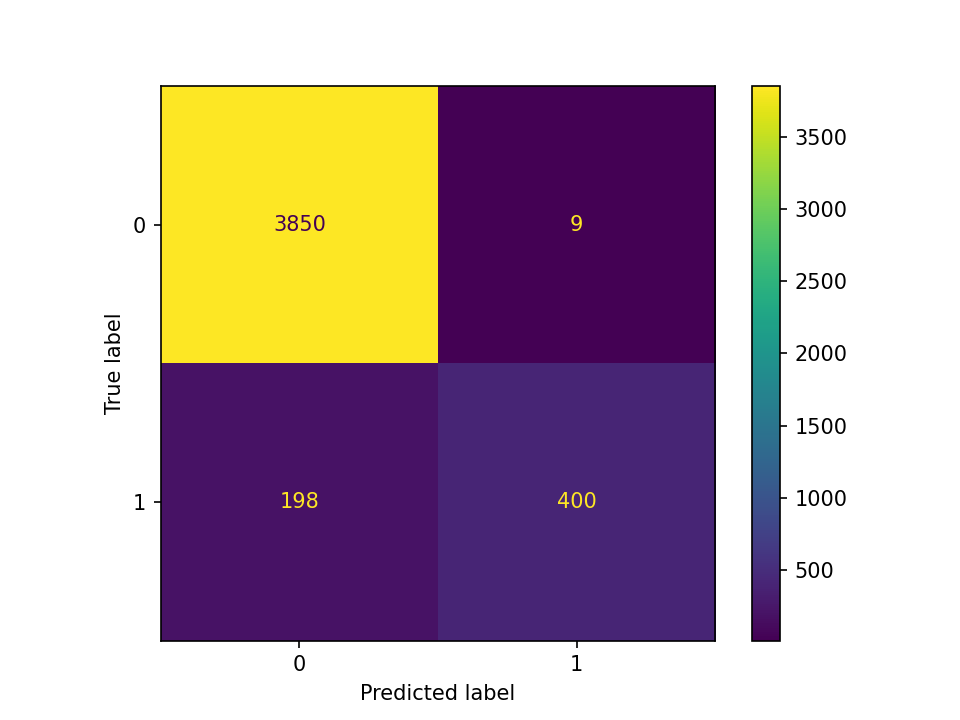

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=lr_clf.classes_)
disp.plot()

**Exercise 2:**

What can you tell from the confusion matrix? What kind of errors does the model more frequently make? 
<br/>
<details><summary>Click here for answer</summary>
It predicts 400 spam messages correctly but got 198 wrong, represents only 66.8% recall rate for 'spam' class. It did however, better at predicting ham messages, which is not suprising, given we have a lot more ham messages in our training set.

<p><br/>
Important lesson here: Just looking at accuracy alone will not give you a full picture of the performance of your model. 
    
</details>

### Precision and Recall

**Exercise 3:**

From the confusion matrix above, compute the precision, recall and F1 score **manually** using the following formula:

- `recall = TP/(TP+FN)`
- `precision = TP/(TP+FP)`
- `F1 = 2*precision*recall/(precision + recall)`

<details><summary>Click here for answer</summary>
    
By convention, we use label 1 as positive case and label 0 as negative case. 
    
From the confusion matrix, we can obtain the following: 
- TP = 400
- FN = 198
- FP = 9
- TN = 3850

Now we can calculate recall, precision, and f1 easily: 

- recall = TP/(TP+FN) = 400/(400+198) = 0.67
- precision = TP/(TP+FP) = 400/(400+9) = 0.98
- f1 = 2\*precision\*recall/(precision+recall) = 0.8

</details>

Now we use the scikit learn's metric function to compute recall, precision and f1_score and compare the values with those manually computed: 
- recall_score()
- precision_score()
- f1_score()

Are they the same as your calculation? 

In [12]:
from sklearn.metrics import recall_score, precision_score, f1_score

print(recall_score(y_train, y_train_pred))
print(precision_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.6688963210702341
0.9779951100244498
0.7944389275074478


The is a another useful function called `classification_report()` in scikit-learn that gives all the metrics in one glance. Note that the ``classification_report()`` provides the precision/recall/f1-score values for each of the class. 

Note that we have different precison and recall scores for each class (0 and 1). 

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3859
           1       0.98      0.67      0.79       598

    accuracy                           0.95      4457
   macro avg       0.96      0.83      0.88      4457
weighted avg       0.95      0.95      0.95      4457



Also note that we have different averages for precision, recall and f1 : macro average and weighted average in the classication_report. What is the difference between the two ? You can refer to this [link](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) for info.  Manually calculate the macro and weighted average to check your understanding. 

### Precision and Recall tradeoff

The confusion matrix and the classification report provide a very detailed analysis of
a particular set of predictions. However, the predictions themselves already threw
away a lot of information that is contained in the model. 

Most classifiers provide a `decision_function()` or a `predict_proba()` method to
assess degrees of certainty about predictions. Making predictions can be seen as
thresholding the output of decision_function or predict_proba at a certain fixed
point— in binary classification we use 0 for the decision function and 0.5 for
predict_proba.

In logistic regression, we can use the `decision_function()` method to compute the scores.   

First let's find a positive sample (using ``np.where`` to find all samples where y label == 1, and uses the first result as sample) and examine the decision score.

In [14]:
idx = np.where(y_train == 1)[0][0]
print(idx)

0


In [15]:
sample_X = X_train_vect[idx]
sample_y = y_train[idx]

y_score = lr_clf.decision_function(sample_X)
print(y_score)

[1.39979965]


With threshold = 0, the prediction (of positive case, i.e. 1) is correct.

In [16]:
threshold = 0
y_some_X_pred = y_score > threshold
print(y_some_X_pred == sample_y)

[ True]


With threshold set at 6, prediction (of positive case, i.e. 1) is wrong. In other words, we failed to detect positive cases (lower recall)

In [17]:
threshold = 6
y_some_data_pred = y_score > threshold
print(y_some_data_pred == sample_y)

[False]


With a higher threshold, it decreases the recall and increases the precision. Conversely, with a lower threshold, we increases recall at the expense of decrease in precision. To decide which threshold to use, get the scores of all instances in the training set using the `cross_val_predict()` function to return decision scores instead of predictions.

Perform cross validation to get the scores for all instances.

In [ ]:
y_scores = cross_val_predict(
    lr_clf, X_train_vect, y_train, cv=5, method="decision_function"
)

Compute precision and recall for all possible thresholds using the precision_recall_curve function.

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

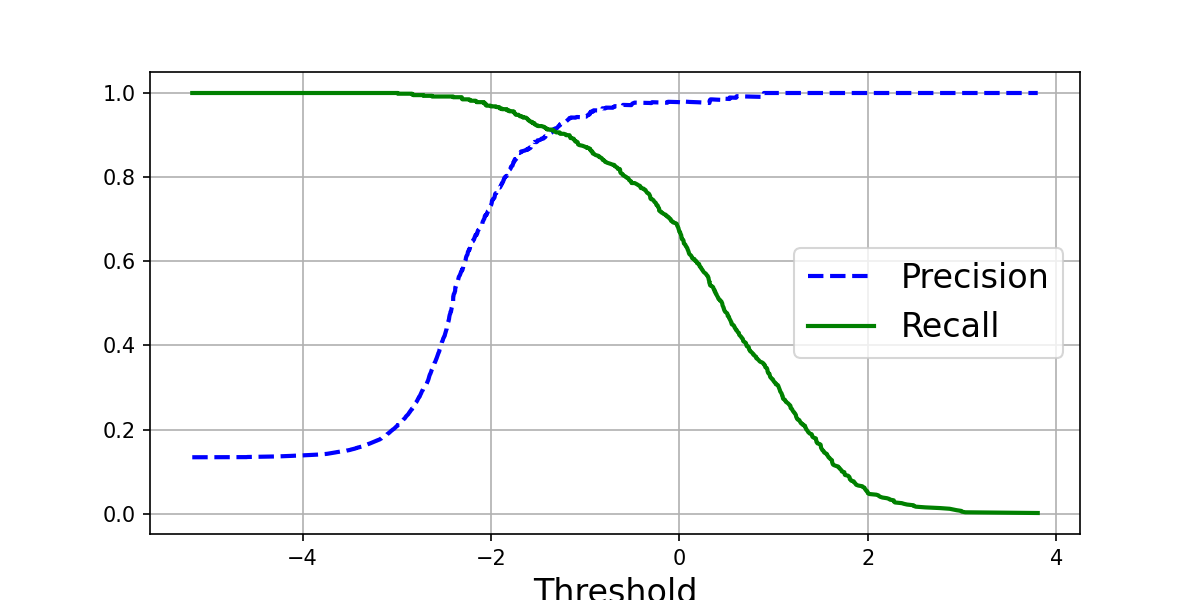

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall.

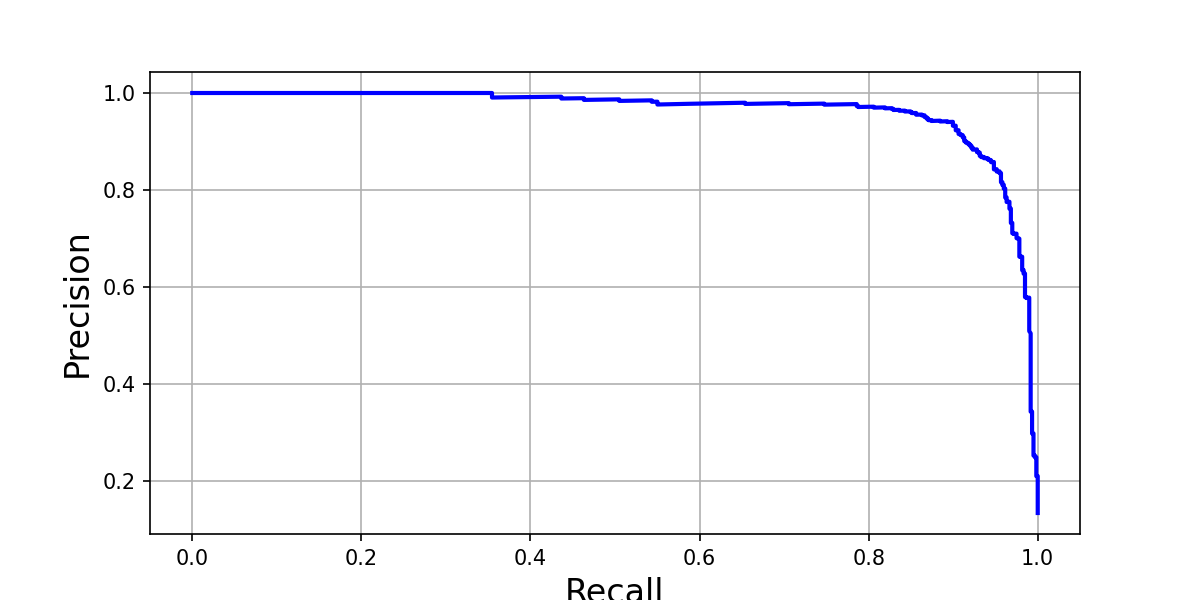

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.grid(True)


plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)

plt.show()

We want to aim for 80% or better recall, compute the threshold value.

In [20]:
threshold_80_recall = thresholds[np.argmin(recalls >= 0.8)]
threshold_80_recall

np.float64(-0.5648355834355416)

In [ ]:
y_train_pred_80 = y_scores >= threshold_80_recall

Compute the precision and recall score

In [21]:
precision_score(y_train, y_train_pred_80)

np.float64(0.9715447154471545)

In [22]:
recall_score(y_train, y_train_pred_80)

np.float64(0.7993311036789298)

In [23]:
print(classification_report(y_train, y_train_pred_80))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3859
           1       0.97      0.80      0.88       598

    accuracy                           0.97      4457
   macro avg       0.97      0.90      0.93      4457
weighted avg       0.97      0.97      0.97      4457



### ROC Curves

The receiver operation characteristic (ROC) curve is another common tool used with binary classifiers.  It is similar to the precision/recall curve, but it plots the true positive rate (recall) against the false positive rate.  

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

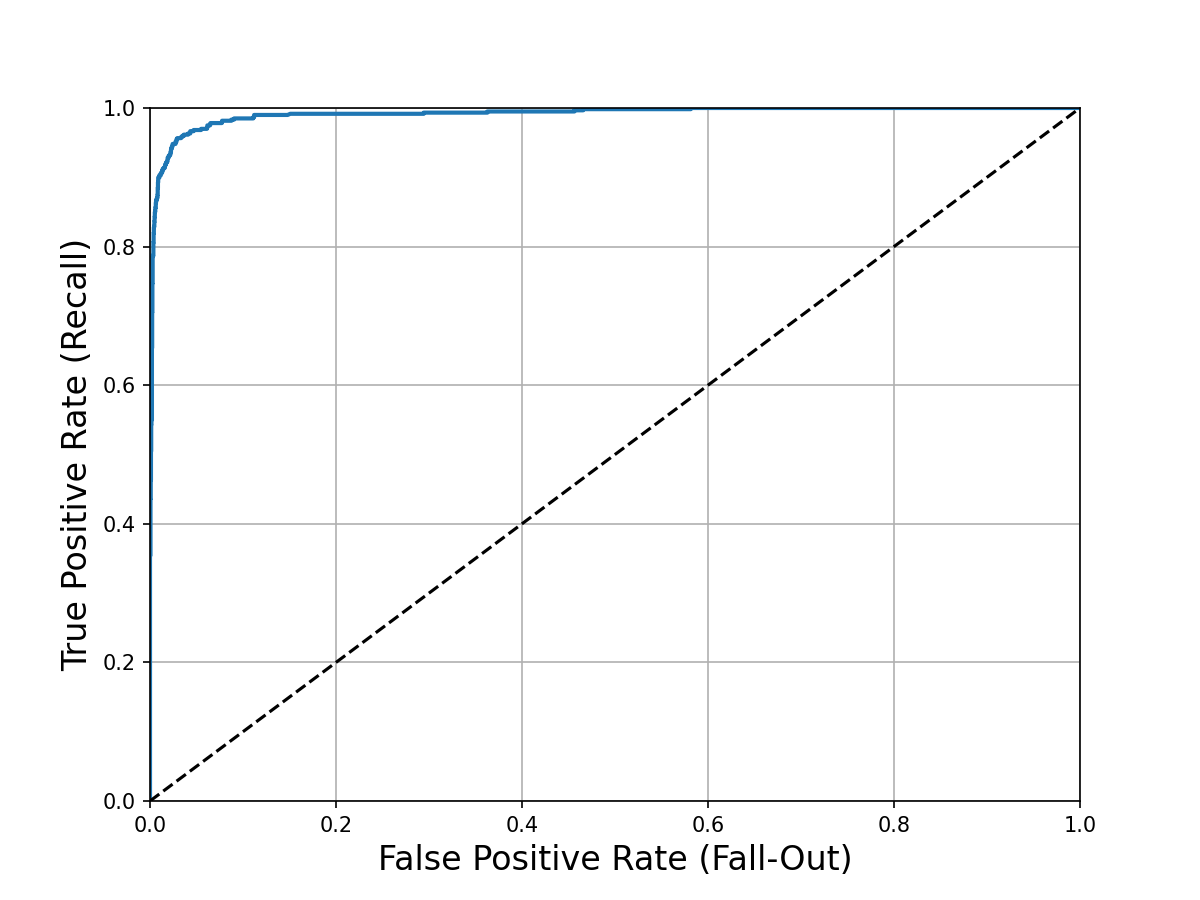

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces.  The dotted line represents the ROC curve of a purely random classifier, a good classfier stays as far away from the line as possible.

Let's Compute the area under the curve (AUC) using `roc_auc_score()`

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

np.float64(0.9914609118587396)

**Exercise 4:**

We are finally done with our binary classification...Wait a minute! Did we just computed all the evaluation metrics on ***training set*** ??!!  Isn't it bad practice to do so.. Don't we need to use ***test set*** to evaluate how good is our model?

Why?

<details><summary>Click here for answer</summary>

We only evaluate our model after we are satisfied with performance of it on our validation set. We will do our model fine-tuning on the validation set and not test set. In our case, since our training set is pretty small, if we are to set aside a validation set, then our training set would be too small. That is why we use ``cross_validation`` to evaluate our model
    
</details>

In [26]:
lr_clf.fit(X_train_vect, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [27]:
lr_clf.score(X_test_vect, y_test)

0.9766816143497757

## Multiclass classification

We will now look at multi-class classification. The dataset we are going to use is the UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit. Each digit is a 8x8 image.  

In [28]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


**Exercise 5:**

Now create the X (the features) and y (the label) from the digits dataset.  X is a np.array of 64 pixel values, while y is the label e.g. 0, 1, 2, 3, .. 9.

<details><summary>Click here for answer</summary>
    
```python
    
X = digits['data']
y = digits['target']

```
</details>

In [ ]:
# Complete your code here

X = digits["data"]
y = digits["target"]

Let's plot the image of a particular digit to visualize it.  Before plotting, we need to reshape the 64 numbers into 8 x 8 image arrays so that it can be plotted.

digit is 4


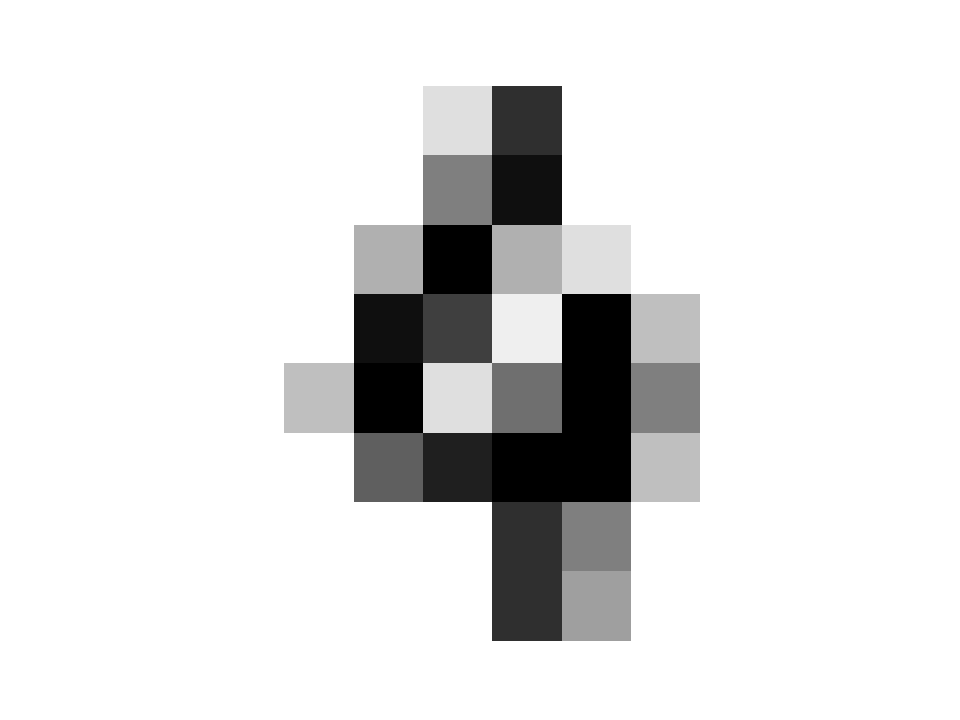

In [29]:
import matplotlib as mpl


# let's choose any one of the row and plot it
some_digit = X[100]

# print out the corresponding label
print("digit is {}".format(y[100]))

# reshape it to 8 x 8 image
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

**Exercise 6**

Split the data into train and test set, and randomly shuffle the data.


<details><summary>Click here for answer</summary>

```python
    
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

```
</details>

In [ ]:
## Complete your code here
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

Multiclass classifiers distinguish between more than two classess.  Scikit-learn detects when you try to use a binary classification algorithm for a multiple class classification task and it automatically runs one-versus-all (OvA)

**Exercise 7**

Use Logistic Regression to train using the training set, and make a prediction of the chosen digit (`some_digit`). Is the prediction correct?

<details><summary>Click here for answer</summary>

```python

lr_clf = LogisticRegression(solver='liblinear', random_state=42)
lr_clf.fit(X_train, y_train)
    
```
</details>

In [30]:
# Complete the code here

lr_clf = LogisticRegression(solver="liblinear", random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image and selected the class with the highest score.  

**Exercise 8**

Compute the scores for `some_digit` using the `decision_function()` method to return 10 scores, one per class.

<details><summary>Click here for answer</summary>

```python
    
some_digit_scores = lr_clf.decision_function([some_digit])
    
```
</details>

In [ ]:
# complete the code here

some_digit_scores = lr_clf.decision_function([some_digit])

In [31]:
some_digit_scores

array([[-12.58028507,  -4.57705248, -35.66600992, -30.71584773,
          9.84359811, -17.11158963,  -7.48193249, -11.46076656,
        -14.4968162 , -34.19968072]])

The highest score is the one corresponding to the correct class.

In [32]:
index = np.argmax(some_digit_scores)
print(index)

4


In [33]:
lr_clf.classes_[index]

np.int64(4)

**Exercise 9**

Use `cross_val_score()` to evaluate the classifier's accuracy.

<details><summary>Click here for answer</summary>
    
```python 
    
cross_val_score(lr_clf, X_train, y_train, cv=3, scoring="accuracy")
    
```
</details>  

In [34]:
# Complete your code here


cross_val_score(lr_clf, X_train, y_train, cv=5, scoring="accuracy").mean()

np.float64(0.9498838559814169)

**Exercise 10**

Compute the confusion matrix of the classifier. From the confusion matrix, which two digits tend to be confused with each other?

<details><summary>Click here for answer</summary>
    
```python 

y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
    
```
<br/>
1 and 8 are confused with each other. 
    
</details>  

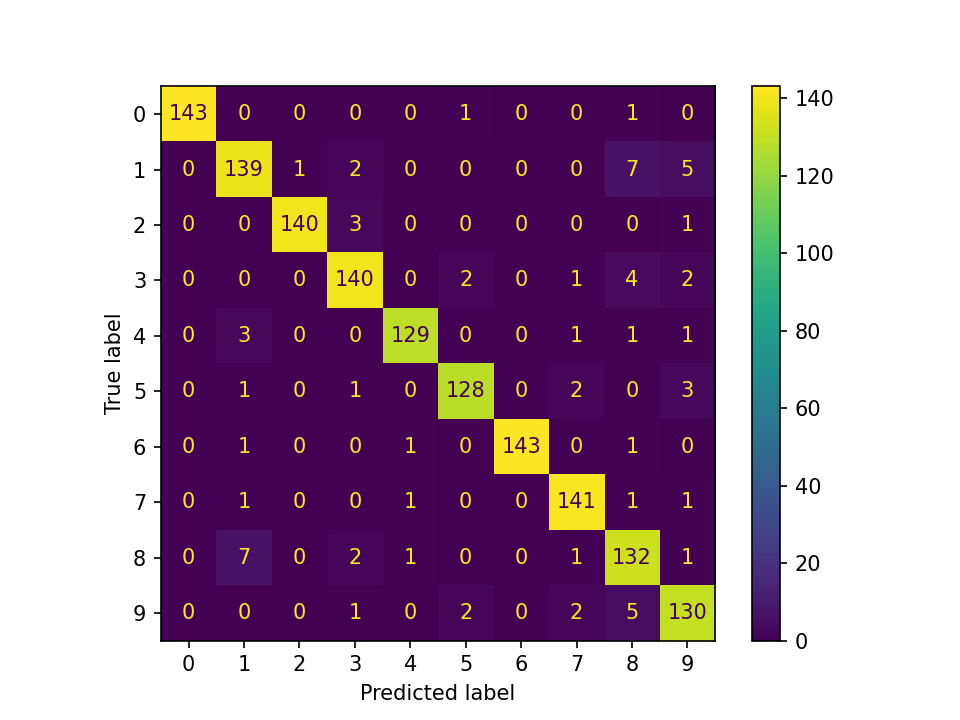

In [35]:
# Complete your code here
y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm).plot()

**Exercise 11**

Print out the classification_report.  

<details><summary>Click here for answer</summary>
    
```python 

print(classification_report(y_train, y_train_pred))
    
```
</details>  

In [36]:
# Complete your code here
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       145
           1       0.91      0.90      0.91       154
           2       0.99      0.97      0.98       144
           3       0.94      0.94      0.94       149
           4       0.98      0.96      0.97       135
           5       0.96      0.95      0.96       135
           6       1.00      0.98      0.99       146
           7       0.95      0.97      0.96       145
           8       0.87      0.92      0.89       144
           9       0.90      0.93      0.92       140

    accuracy                           0.95      1437
   macro avg       0.95      0.95      0.95      1437
weighted avg       0.95      0.95      0.95      1437



Question: Any algorithm only suitable for Binary classification? Any algorithm only suitable for multiclass classification?
Let try out others classification algorithm and compare the result.